Dans ce notebook, on va utiliser le type de bâtiment mais pas les usages principaux

In [69]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import sklearn
sklearn.set_config(transform_output = "pandas")

from sklearn.preprocessing import OneHotEncoder, TargetEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_absolute_percentage_error as mape, mean_squared_error as mse
from sklearn.linear_model import LinearRegression

import warnings
#warnings.filterwarnings("ignore")

from utils import *

In [70]:
df = pd.read_csv('df_clean.csv', index_col=0)
print(df.shape)

(1578, 20)


In [71]:
df.head()

,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,Hotel,7,DOWNTOWN,1927,12,88434,Hotel,88434.0,NaN,0.0,NaN,0.0,60.0,84.300003,7456910.0,2003882.00,3946027.0,1276453.0,249.98,2.83
1,Hotel,7,DOWNTOWN,1996,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,8664479.0,0.00,3242851.0,5145082.0,295.86,2.86
2,Hotel,7,DOWNTOWN,1969,41,956110,Hotel,756493.0,NaN,0.0,NaN,0.0,43.0,97.699997,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,2.19
3,Hotel,7,DOWNTOWN,1926,10,61320,Hotel,61320.0,NaN,0.0,NaN,0.0,56.0,113.300003,6946800.5,2214446.25,2768924.0,1811213.0,286.43,4.67
4,Hotel,7,DOWNTOWN,1980,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,14656503.0,0.00,5368607.0,8803998.0,505.01,2.88


# Prédiction sur la consommation non normalisée

Pour commencer on va utiliser peu de variables pour la modélisation, puis on en rajoutera au fur et à mesure

## Train/Test split

In [72]:
X = df[['SiteEnergyUseWN(kBtu)', 'PrimaryPropertyType', 'CouncilDistrictCode', 'PropertyGFATotal']]
y = X.pop('SiteEnergyUseWN(kBtu)')
print('X shape :', X.shape)
print('y shape :', y.shape)
display(X.head())
display(y.head())

X shape : (1578, 3)
y shape : (1578,)


,PrimaryPropertyType,CouncilDistrictCode,PropertyGFATotal
0,Hotel,7,88434
1,Hotel,7,103566
2,Hotel,7,956110
3,Hotel,7,61320
4,Hotel,7,175580


0     7456910.0
1     8664479.0
2    73937112.0
3     6946800.5
4    14656503.0
Name: SiteEnergyUseWN(kBtu), dtype: float64

On va changer les types des données

In [73]:
X.dtypes

PrimaryPropertyType    object
CouncilDistrictCode     int64
PropertyGFATotal        int64
dtype: object

In [74]:
X.memory_usage() / 1024

Index                  12.328125
PrimaryPropertyType    12.328125
CouncilDistrictCode    12.328125
PropertyGFATotal       12.328125
dtype: float64

In [75]:
X["PrimaryPropertyType"] = X["PrimaryPropertyType"].astype("category")
X["CouncilDistrictCode"] = X["CouncilDistrictCode"].astype("category")
X["PropertyGFATotal"] = pd.to_numeric(X["PropertyGFATotal"], downcast="integer")

In [76]:
X.dtypes

PrimaryPropertyType    category
CouncilDistrictCode    category
PropertyGFATotal          int32
dtype: object

In [77]:
X.memory_usage() / 1024

Index                  12.328125
PrimaryPropertyType     2.232422
CouncilDistrictCode     1.888672
PropertyGFATotal        6.164062
dtype: float64

Même chose avec y

In [78]:
print(y.dtype)
print(y.memory_usage(index=False) / 1024)

float64
12.328125


In [79]:
y = pd.to_numeric(y, downcast="float")
print(y.dtype)
print(y.memory_usage(index=False) / 1024)

float32
6.1640625


Train-Test split :

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (1262, 3)
y_train shape : (1262,)
X_test shape : (316, 3)
y_test shape : (316,)


## Preprocessing

### Encodage

Différents types d'encodage à tester :
- [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- [TargetEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder)
- [GLMMEncoder](https://contrib.scikit-learn.org/category_encoders/glmm.html)
- [LeaveOneOutEncoder](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html)
- [MEstimateEncoder](https://contrib.scikit-learn.org/category_encoders/mestimate.html)
- [HashingEncoder](https://contrib.scikit-learn.org/category_encoders/hashing.html)

Lien utiles :
- https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques
- https://towardsdatascience.com/6-ways-to-encode-features-for-machine-learning-algorithms-21593f6238b0
- https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
- https://contrib.scikit-learn.org/category_encoders/

#### Encodage One-hot

On va effectuer un encodage One-Hot pour les variables catégorielles et et une standardisation Min-Max pour les variables numériques.

Vérifions que toutes les catégories sont présentes dans le jeu d'entrainement

In [81]:
print('X', X[['PrimaryPropertyType', 'CouncilDistrictCode']].nunique(), sep='\n')
print()
print('X_train', X_train[['PrimaryPropertyType', 'CouncilDistrictCode']].nunique(), sep='\n')

X
PrimaryPropertyType    19
CouncilDistrictCode     7
dtype: int64

X_train
PrimaryPropertyType    19
CouncilDistrictCode     7
dtype: int64


In [82]:
def custom_combiner(feature, category):
    return str(category)

col_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=np.int8, feature_name_combiner=custom_combiner), ['PrimaryPropertyType']),
    (OneHotEncoder(sparse_output=False, dtype=np.int8), ['CouncilDistrictCode']),
    remainder=MinMaxScaler(),
    verbose_feature_names_out=False
)
col_transformer

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder-1',
                                 OneHotEncoder(dtype=<class 'numpy.int8'>,
                                               feature_name_combiner=<function custom_combiner at 0x136e37ce0>,
                                               sparse_output=False),
                                 ['PrimaryPropertyType']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype=<class 'numpy.int8'>,
                                               sparse_output=False),
                                 ['CouncilDistrictCode'])],
                  verbose_feature_names_out=False)

In [83]:
X_transform = col_transformer.fit_transform(X_train)
print('X_transform shape :', X_transform.shape)
X_transform.head()

X_transform shape : (1262, 27)


,Distribution Center,Hospital,Hotel,K-12 School,Laboratory,Large Office,Medical Office,Mixed Use Property,Other,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Small- and Mid-Sized Office,Supermarket / Grocery Store,University,Warehouse,Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,PropertyGFATotal
300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.018968
2207,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.011862
2998,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.005809
3187,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.145617
257,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.053691


In [84]:
# dtypes
X_transform.dtypes.value_counts()

int8       26
float64     1
Name: count, dtype: int64

In [85]:
# memory usage in kB
X_transform.memory_usage().sum() / 1024

51.76171875

## Entrainement d'un modèle dans une pipeline

On va tester un simple algorithme de régression linéaire que l'on va intégrer dans une pipeline contenant le preprocessing avant l'ajustement du modèle.

In [86]:
pipeline = make_pipeline(col_transformer, LinearRegression())
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder-1',
                                                  OneHotEncoder(dtype=<class 'numpy.int8'>,
                                                                feature_name_combiner=<function custom_combiner at 0x136e37ce0>,
                                                                sparse_output=False),
                                                  ['PrimaryPropertyType']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(dtype=<class 'numpy.int8'>,
                                                                sparse_output=False),
                                                  ['CouncilDistrictCode'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [87]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder-1',
                                                  OneHotEncoder(dtype=<class 'numpy.int8'>,
                                                                feature_name_combiner=<function custom_combiner at 0x136e37ce0>,
                                                                sparse_output=False),
                                                  ['PrimaryPropertyType']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(dtype=<class 'numpy.int8'>,
                                                                sparse_output=False),
                                                  ['CouncilDistrictCode'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

Résultats sur le jeu d'entrainement

In [88]:
y_pred = pipeline.predict(X_train)
print('R2 :', r2_score(y_train, y_pred))
print('MSE :', mse(y_train, y_pred))
print('MAE :', mae(y_train, y_pred))
print('MAPE :', mape(y_train, y_pred))

R2 : 0.6552295150798304
MSE : 148749053239358.9
MAE : 4414832.646676282
MAPE : 1.5792748250708524


Résultats sur le jeu de test

In [89]:
y_pred = pipeline.predict(X_test)
print('R2 :', r2_score(y_test, y_pred))
print('MSE :', mse(y_test, y_pred))
print('MAE :', mae(y_test, y_pred))
print('MAPE :', mape(y_test, y_pred))

R2 : 0.170998206224247
MSE : 677615855415889.9
MAE : 5154703.867212223
MAPE : 1.4011663886440855


Il y a clairement de l'overfitting sur ce modèle simple

## Comparaison de modèles

In [90]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RANSACRegressor, QuantileRegressor, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, 
                              GradientBoostingRegressor, HistGradientBoostingRegressor)
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import time

import warnings
warnings.filterwarnings("ignore")

In [91]:
models = {'dummy': DummyRegressor(strategy='mean'),
          'lin_reg': LinearRegression(),
          'ridge': Ridge(random_state=42),
          'lasso': Lasso(random_state=42),
          #'ransac': RANSACRegressor(random_state=42),
          'quantile': QuantileRegressor(solver='highs'),
          'sgd': SGDRegressor(random_state=42),
          'lin_svm': LinearSVR(random_state=42),
          'knn': KNeighborsRegressor(),
          'pls1': PLSRegression(),
          'gaussian': GaussianProcessRegressor(random_state=42),
          'forest': RandomForestRegressor(random_state=42),
          'bagging': BaggingRegressor(random_state=42),
          'adaboost': AdaBoostRegressor(random_state=42),
          'gradboost': GradientBoostingRegressor(random_state=42),
          'histgboost': HistGradientBoostingRegressor(random_state=42),
          'xgb': XGBRegressor(random_state=42),
          'neur_net': MLPRegressor(hidden_layer_sizes=[10]*10, random_state=42)
         }

model_results = model_comparison(models, X_train, y_train, X_test, y_test, col_transformer)

_____________________________________________________________________________________
model			 train_score	 test_score	 fit_time	 predict_time
dummy       		 0.000		 -0.000		 0.014s		 0.007s
-------------------------------------------------------------------------------------
lin_reg     		 0.655		 0.171		 0.01s		 0.006s
-------------------------------------------------------------------------------------
ridge       		 0.654		 0.168		 0.011s		 0.006s
-------------------------------------------------------------------------------------
lasso       		 0.658		 0.177		 0.039s		 0.006s
-------------------------------------------------------------------------------------
quantile    		 -0.071		 -0.042		 0.09s		 0.004s
-------------------------------------------------------------------------------------
sgd         		 0.657		 0.170		 0.108s		 0.006s
-------------------------------------------------------------------------------------
lin_svm     		 -0.157		 -0.089		 0.008s		 0.005s
---------

forest      		 0.952		 0.196		 0.51s		 0.014s
-------------------------------------------------------------------------------------
bagging     		 0.930		 0.179		 0.054s		 0.006s
-------------------------------------------------------------------------------------
adaboost    		 0.837		 0.221		 0.027s		 0.005s
-------------------------------------------------------------------------------------
gradboost   		 0.941		 0.174		 0.107s		 0.005s
-------------------------------------------------------------------------------------
histgboost  		 0.675		 0.243		 0.186s		 0.006s
-------------------------------------------------------------------------------------
xgb         		 0.995		 0.199		 0.137s		 0.007s
-------------------------------------------------------------------------------------
neur_net    		 0.633		 0.130		 1.272s		 0.004s
-------------------------------------------------------------------------------------


In [92]:
model_results.sort_values(by="test_score", ascending=False)

,train_score,test_score,fit_time,predict_time
model,,,,
histgboost,0.6750,0.2429,0.1863,0.0062
adaboost,0.8367,0.2213,0.0266,0.0055
xgb,0.9954,0.1990,0.1367,0.0065
forest,0.9525,0.1957,0.5102,0.0139
bagging,0.9302,0.1790,0.0543,0.0061
lasso,0.6583,0.1768,0.0393,0.0060
gradboost,0.9407,0.1743,0.1073,0.0047
lin_reg,0.6552,0.1710,0.0096,0.0059
sgd,0.6569,0.1699,0.1079,0.0060


## Prédictions avec XGBoost

Sur toutes les caractéristiques sauf `ThirdLargestPropertyUseTypeGFA` et `ThirdLargestPropertyUseType` qui contient trop de valeurs manquantes

In [111]:
cols_todrop = ["ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA", "SiteEUIWN(kBtu/sf)", "SiteEnergyUseWN(kBtu)",
               "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)", "TotalGHGEmissions", "GHGEmissionsIntensity"]
X = df.drop(columns=cols_todrop)
X.head()

,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore
0,Hotel,7,DOWNTOWN,1927,12,88434,Hotel,88434.0,NaN,0.0,60.0
1,Hotel,7,DOWNTOWN,1996,11,103566,Hotel,83880.0,Parking,15064.0,61.0
2,Hotel,7,DOWNTOWN,1969,41,956110,Hotel,756493.0,NaN,0.0,43.0
3,Hotel,7,DOWNTOWN,1926,10,61320,Hotel,61320.0,NaN,0.0,56.0
4,Hotel,7,DOWNTOWN,1980,18,175580,Hotel,123445.0,Parking,68009.0,75.0


In [112]:
X.dtypes

PrimaryPropertyType                 object
CouncilDistrictCode                  int64
Neighborhood                        object
YearBuilt                            int64
NumberofFloors                       int64
PropertyGFATotal                     int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ENERGYSTARScore                    float64
dtype: object

In [113]:
for col in X.select_dtypes(object):
    X[col] = X[col].astype("category")
for col in X.select_dtypes(int):
    X[col] = pd.to_numeric(X[col], downcast="integer")
for col in X.select_dtypes(float):
    X[col] = pd.to_numeric(X[col], downcast="float")
X.dtypes

PrimaryPropertyType                category
CouncilDistrictCode                    int8
Neighborhood                       category
YearBuilt                             int16
NumberofFloors                         int8
PropertyGFATotal                      int32
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float32
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float32
ENERGYSTARScore                     float32
dtype: object

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist")
model.fit(X_train, y_train)

model_evaluation_2(model, X_train, X_test, y_train, y_test)

Score          Train          Test           
R2             1.0            0.24           
MAPE           0.088          0.712          
MAE            137578.95      4372832.5      
MedAE          81909.0        996892.75      


### Grid Search

In [115]:
from sklearn.model_selection import GridSearchCV

évaluation sur le $R^2$ :

In [116]:
%%time
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.75, 1],
}

# Create the XGBoost model object
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist")

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best score:  0.7100022609178132
CPU times: user 2.59 s, sys: 192 ms, total: 2.78 s
Wall time: 9.66 s


In [117]:
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist", **grid_search.best_params_)
xgb.fit(X_train, y_train)

model_evaluation_2(xgb, X_train, X_test, y_train, y_test)

Score          Train          Test           
R2             0.997          0.164          
MAPE           0.394          0.664          
MAE            803299.06      4906201.5      
MedAE          533609.9       1066091.2      


évaluation sur la MAE :

In [118]:
%%time
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.75, 1],
}

# Create the XGBoost model object
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist")

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best score:  -3267924.35
CPU times: user 2.6 s, sys: 106 ms, total: 2.7 s
Wall time: 8.94 s


In [119]:
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist", **grid_search.best_params_)
xgb.fit(X_train, y_train)

model_evaluation_2(xgb, X_train, X_test, y_train, y_test)

Score          Train          Test           
R2             0.997          0.164          
MAPE           0.394          0.664          
MAE            803299.06      4906201.5      
MedAE          533609.9       1066091.2      


Même résultats qu'en évaluant sur le $R^2$, le modèle overfit clairement

## XGBoost avec quelques caractéristiques

In [120]:
X = df[['PrimaryPropertyType', 'CouncilDistrictCode', 'PropertyGFATotal']]
X["PrimaryPropertyType"] = X["PrimaryPropertyType"].astype("category")
X["CouncilDistrictCode"] = X["CouncilDistrictCode"].astype("category")
X["PropertyGFATotal"] = pd.to_numeric(X["PropertyGFATotal"], downcast="integer")

In [121]:
X.isna().mean()

PrimaryPropertyType    0.0
CouncilDistrictCode    0.0
PropertyGFATotal       0.0
dtype: float64

In [122]:
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist")
xgb.fit(X_train, y_train)

y_fit, y_pred = model_evaluation_2(xgb, X_train, X_test, y_train, y_test, return_preds=True)

Score          Train          Test           
R2             1.0            0.24           
MAPE           0.088          0.712          
MAE            137578.95      4372832.5      
MedAE          81909.0        996892.75      


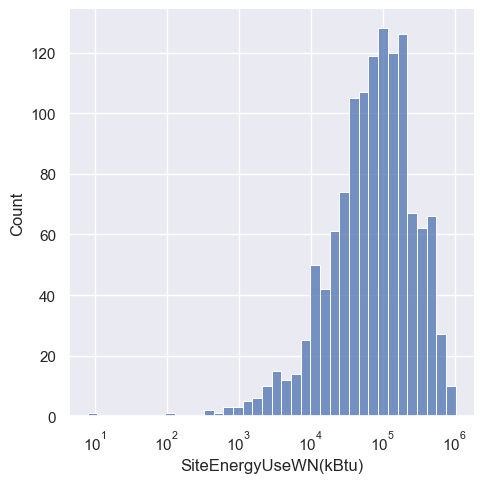

In [123]:
residuals = np.abs(y_train - y_fit)
sns.displot(x=residuals, log_scale=True)

### Grid Search

In [124]:
from sklearn.model_selection import GridSearchCV

évaluation sur le $R^2$ :

In [125]:
%%time
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.75, 1],
}

# Create the XGBoost model object
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist")

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best score:  0.7100022609178132
CPU times: user 2.62 s, sys: 96.9 ms, total: 2.72 s
Wall time: 7.69 s


In [126]:
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist", **grid_search.best_params_)
xgb.fit(X_train, y_train)

model_evaluation_2(xgb, X_train, X_test, y_train, y_test)

Score          Train          Test           
R2             0.997          0.164          
MAPE           0.394          0.664          
MAE            803299.06      4906201.5      
MedAE          533609.9       1066091.2      


évaluation sur la MAE :

In [127]:
%%time
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.75, 1],
}

# Create the XGBoost model object
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist")

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best score:  -3267924.35
CPU times: user 3.09 s, sys: 160 ms, total: 3.25 s
Wall time: 7.73 s


In [128]:
xgb = XGBRegressor(random_state=0, enable_categorical=True, tree_method="hist", **grid_search.best_params_)
xgb.fit(X_train, y_train)

model_evaluation_2(xgb, X_train, X_test, y_train, y_test)

Score          Train          Test           
R2             0.997          0.164          
MAPE           0.394          0.664          
MAE            803299.06      4906201.5      
MedAE          533609.9       1066091.2      


R2 moins bon sur le test mais amélioration sur la MAPE.

## Rajout des variables `YearBuilt` et `NumberofFloors`

On va discrétiser les variables `YearBuilt` et `NumberofFloors` (voir [ce lien](https://scikit-learn.org/stable/modules/preprocessing.html#discretization) pour plus d'informations)

In [131]:
from sklearn.preprocessing import KBinsDiscretizer

In [132]:
X_ = df[['YearBuilt']]
X_.head()

,YearBuilt
0,1927
1,1996
2,1969
3,1926
4,1980


In [133]:
nbins = 10
est = KBinsDiscretizer(n_bins=nbins, encode='ordinal', strategy='quantile', subsample=None)
X_transform = est.fit_transform(X_)
X_transform.head()

,YearBuilt
0,2.0
1,8.0
2,5.0
3,2.0
4,6.0


In [134]:
est.bin_edges_

array([array([1900. , 1912. , 1926. , 1948. , 1958. , 1965. , 1973. , 1983.9,
              1995. , 2003. , 2015. ])                                       ],
      dtype=object)

<Axes: xlabel='YearBuilt', ylabel='Count'>

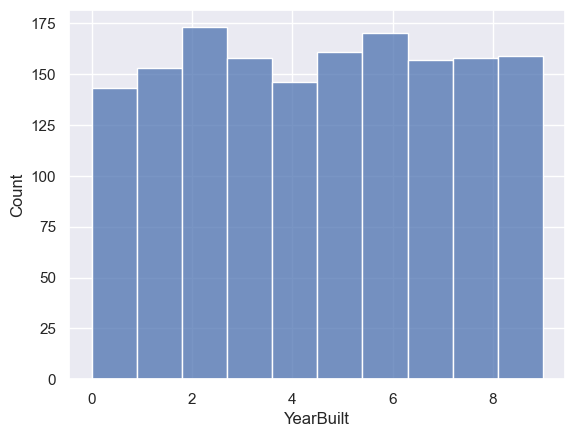

In [135]:
sns.histplot(data=X_transform, x='YearBuilt', bins=nbins)

<Axes: xlabel='YearBuilt', ylabel='SiteEnergyUseWN(kBtu)'>

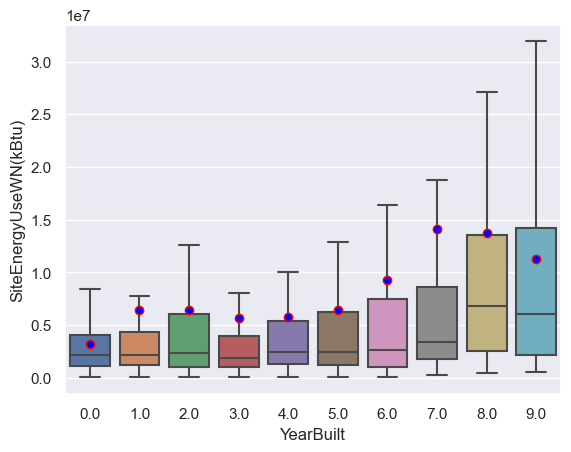

In [136]:
sns.boxplot(x=X_transform['YearBuilt'], y=df['SiteEnergyUseWN(kBtu)'], showfliers=False, showmeans=True,
            meanprops={"marker": "o",
                       "markeredgecolor": "red",
                       "markerfacecolor": "blue",
                       "markersize": "6"})

TODO : il faut chercher à maximiser le $R^2$ (ou bien le $\eta^2$), c'est-à-dire le rapport entre la variance interclasse (somme des carrés estimés) et la variance totale (somme des carrés totaux).
Voir ce cours [Openclassrooms](https://openclassrooms.com/fr/courses/7410486-nettoyez-et-analysez-votre-jeu-de-donnees/7428558-analysez-une-variable-quantitative-et-une-qualitative-par-anova) et le notebook __Réalisez des modélisations de données performantes/TP 4 - Pratiquez l'analyse de la variance sur le jeu de données du blé.ipynb__ dans les téléchargements.

Calcul du $\eta^2$ et de la p-value pour différents nombres d'intervalles : (rajouter la p-value)

In [137]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [166]:
x = df[["YearBuilt"]]
y = df['SiteEnergyUseWN(kBtu)']
nbins = 50
eta_dic = {}
for n in range(2, nbins):
    est = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='quantile', subsample=None)
    xt = est.fit_transform(x)["YearBuilt"]
    #print("bins :", list(xt.value_counts().sort_index().index))
    eta_dic[n] = eta_squared(xt, y)

In [175]:
s_eta = pd.Series(eta_dic)
s_eta.head()

2    0.014094
3    0.023852
4    0.022548
5    0.019485
6    0.024077
dtype: float64

In [176]:
s_eta.max()

0.04558369242003886

In [177]:
s_eta.argmax()

40

In [178]:
s_eta.idxmax()

42

In [179]:
s_eta.iloc[40]

0.04558369242003886

In [180]:
s_eta.loc[42]

0.04558369242003886

# Prédiction sur le log de la target non normalisée